In [1]:
%cd "../"
%pwd

import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *
from crossValidation import *

C:\Users\alexi\Desktop\Memory_genes\src


In [2]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [3]:
#Load preprocess data
AE7= np.array(pd.read_csv ('../data/processed_data/AE7.csv'))
y = np.array(AE7[:,-1],dtype=int)
AE7 = AE7[:,0:-1]


In [4]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE7,y)

In [5]:
print(AE7.shape, len(pred))
acc = model.score_
print(acc, model.recovery)

(363, 8987) 363
0.017467248908296942 0.8484848484848485


In [6]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (4, 225, 0.017777777777777778, 0.04040404040404041, 0.9892918332381496, 0.017467248908296942, 0.9954506273345465, 0.982532751091703, 0.9595959595959596)


# Mutual information maximizer (MIM)

test 0.06087503933449061 0.033498669133613844
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (49, 222, 0.22072072072072071, 0.34507042253521125, 0.9884012539184953, 0.18081180811808117, 0.9951080953132397, 0.8191881918819188, 0.6549295774647887)


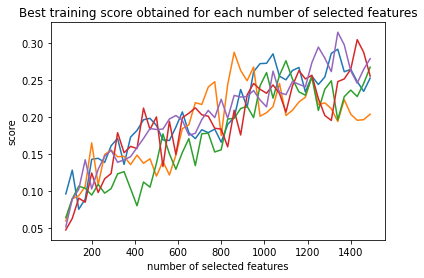

In [7]:
#Define parameters for MIM method
N = np.arange(80,1500,30)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'n_neighbors': 3, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE7, FamiliesClusters, compute_precision,True, 5,  MIM, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_RI,True)
x_subset = AE7[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

In [8]:
get_best_genes_names(subset, '../data/processed_data/AE3genes_interest.csv', '../data/optimized_subsets/AE7genes_bestMIM.csv')

# Anova F test

test 0.08154535595529383 0.034661925566452964
TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (79, 177, 0.4463276836158192, 0.5031847133757962, 0.9910375208871335, 0.30859375, 0.9960305343511451, 0.69140625, 0.4968152866242038)
1830


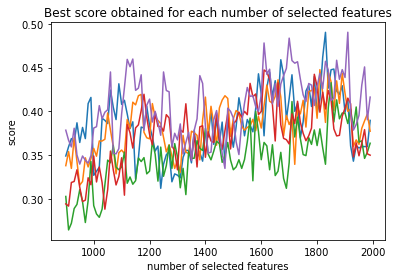

In [9]:
#Define parameters for ANOVA method
N = np.arange(900,2000,10)
kwargs = {'Model': FamiliesClusters, 'Scoring': compute_precision,'maximize': True,'N': N, 'plot': True} 

subset, score_training, score_testing = cross_validation(y,AE7, FamiliesClusters, compute_precision,True, 5,  ANOVA, **kwargs)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

#Predict and evaluate on whole data  set
model = FamiliesClusters(np.unique(y),compute_precision,True)
x_subset = AE7[:, subset]
pred = model.fit_predict(x_subset,y)

print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))    
print(len(subset))

In [10]:
get_best_genes_names(subset, '../data/processed_data/AE7genes_interest.csv', '../data/optimized_subsets/AE7genes_bestANOVA.csv')

# Optmization without CV

1875 0.19696969696969696


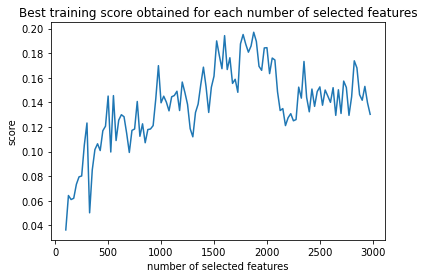

In [7]:
#Run MIM optimization
N = np.arange(100,3000,25)
best_subset, best_score = MIM(y, AE7, FamiliesClusters, compute_precision, True, N, 3, plot=True)
print(len(best_subset), best_score)

In [8]:
#Only keep the optimized genes
norm_subset = AE7[:,best_subset]

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)
    
#Predicting once 
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(np.array(norm_subset),np.array(y))
print('Clustering once')
print('precision: ', model.score_, ' recovery: ', model.recovery)
    
#Predicting 101 times and majority vote (cutoff = 0.5)
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = np.array(norm_subset), y= np.array(y))
print('Clustering 101 times and majority vote')
print('precision: ', model.score_, ' recovery: ', model.recovery)

get_best_genes_names(best_subset,'../data/processed_data/AE7genes_interest.csv', '../data/optimized_subsets/AE7genes_bestMIM.csv')

Clustering once
precision:  0.19696969696969696  recovery:  0.9090909090909091
Clustering 101 times and majority vote
precision:  0.5777777777777777  recovery:  0.21487603305785125


2225 0.3244274809160305


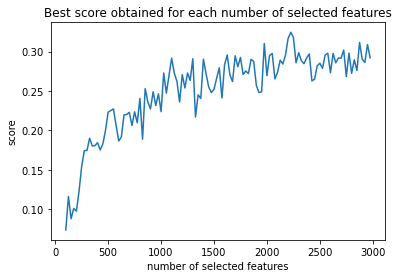

In [9]:
#Run ANOVA optimization
N = np.arange(100,3000,25)
best_subset, best_score = ANOVA(y, AE7, FamiliesClusters, compute_precision, True, N, plot=True)
print(len(best_subset), best_score)

In [10]:
#Only keep the optimized genes
norm_subset = AE7[:,best_subset]

subset = np.ones((len(best_subset),))
subsets = subsampling_genes(subset, 101, 0.25)
    
#Predicting once 
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(np.array(norm_subset),np.array(y))
print('Clustering once')get_best_genes_names(best_subset,'../data/processed_data/AE7genes_interest.csv', '../data/optimized_subsets/AE7genes_bestANOVA.csv')
print('precision: ', model.score_, ' recovery: ', model.recovery)
    
#Predicting 101 times and majority vote (cutoff = 0.5)
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = np.array(norm_subset), y= np.array(y))
print('Clustering 101 times and majority vote')
print('precision: ', model.score_, ' recovery: ', model.recovery)
    


Clustering once
precision:  0.3244274809160305  recovery:  0.8980716253443526
Clustering 101 times and majority vote
precision:  0.5921052631578947  recovery:  0.3443526170798898


2719 0.3371647509578544


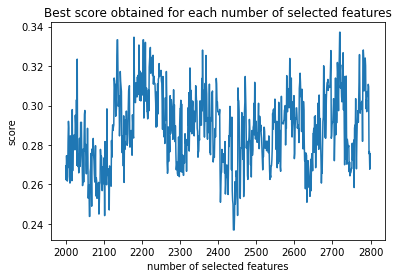

In [4]:
#Run ANOVA optimization
N = np.arange(2000,2800,1)
best_subset, best_score = ANOVA(y, AE7, FamiliesClusters, compute_precision, True, N, plot=True)
print(len(best_subset), best_score)

In [5]:
get_best_genes_names(best_subset,'../data/processed_data/AE7genes_interest.csv', '../data/optimized_subsets/AE7genes_bestANOVA.csv')